In [ ]:
from google.colab import drive
# mount our Google Drive at /gdrive
drive.mount('/gdrive')
!rm -r sample_data/

# copy all files from "ML_Data" directory in Google drive to current directory
!cp -r /gdrive/MyDrive/2021-nycu-ml-hw5/* .

In [ ]:
import json
import numpy as np

with open('train.json') as f:
  json_data = json.load(f)

cuisines = []
ingredients = []

labels = []
features = []

for entry in json_data:
  if entry['cuisine'] not in cuisines:
    cuisines.append(entry['cuisine'])
  labels.append(cuisines.index(entry['cuisine']))
  feature = []
  for ingredient in entry['ingredients']:
    if ingredient not in ingredients:
      ingredients.append(ingredient)
    feature.append(ingredients.index(ingredient))
  features.append(np.array(feature))

**Plot the data distribution by value count of their labels (targets)**

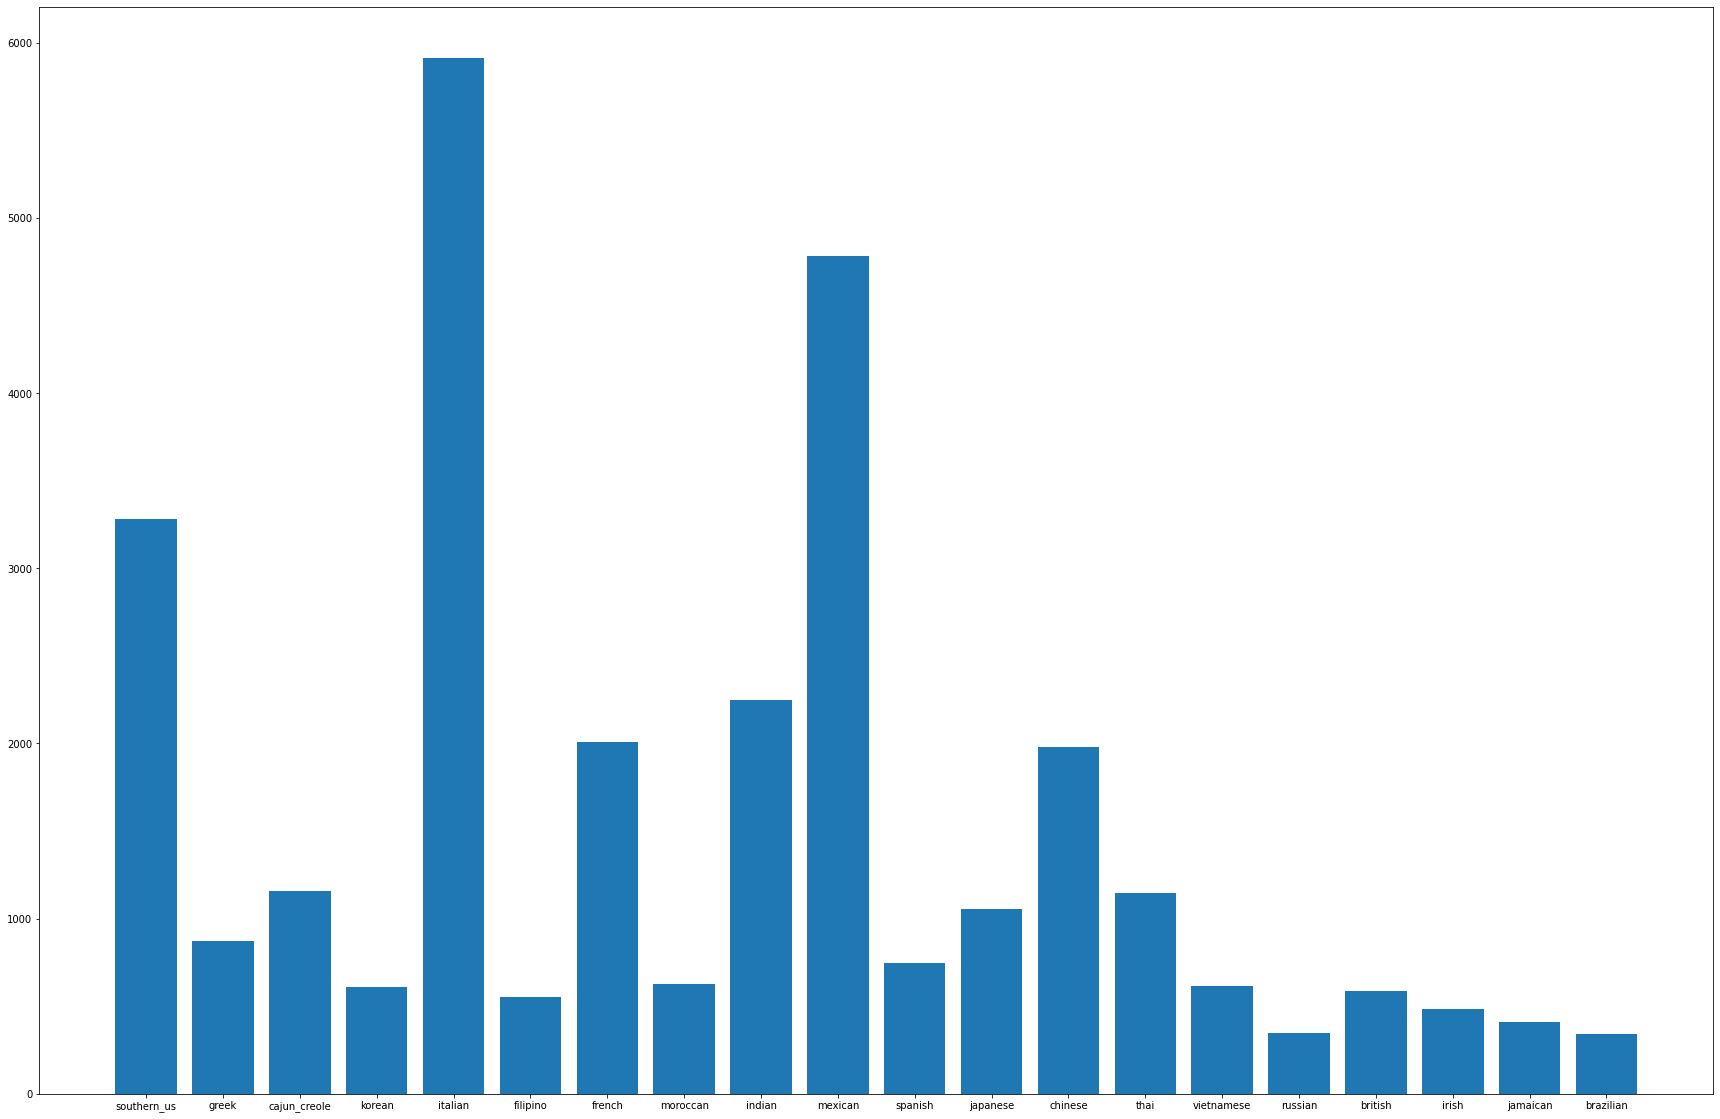

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (30,20))
(x, y) = np.unique(labels, return_counts=True)
plt.bar(cuisines, y)
plt.show()

**Plot the data distribution by value count of top 30 features**

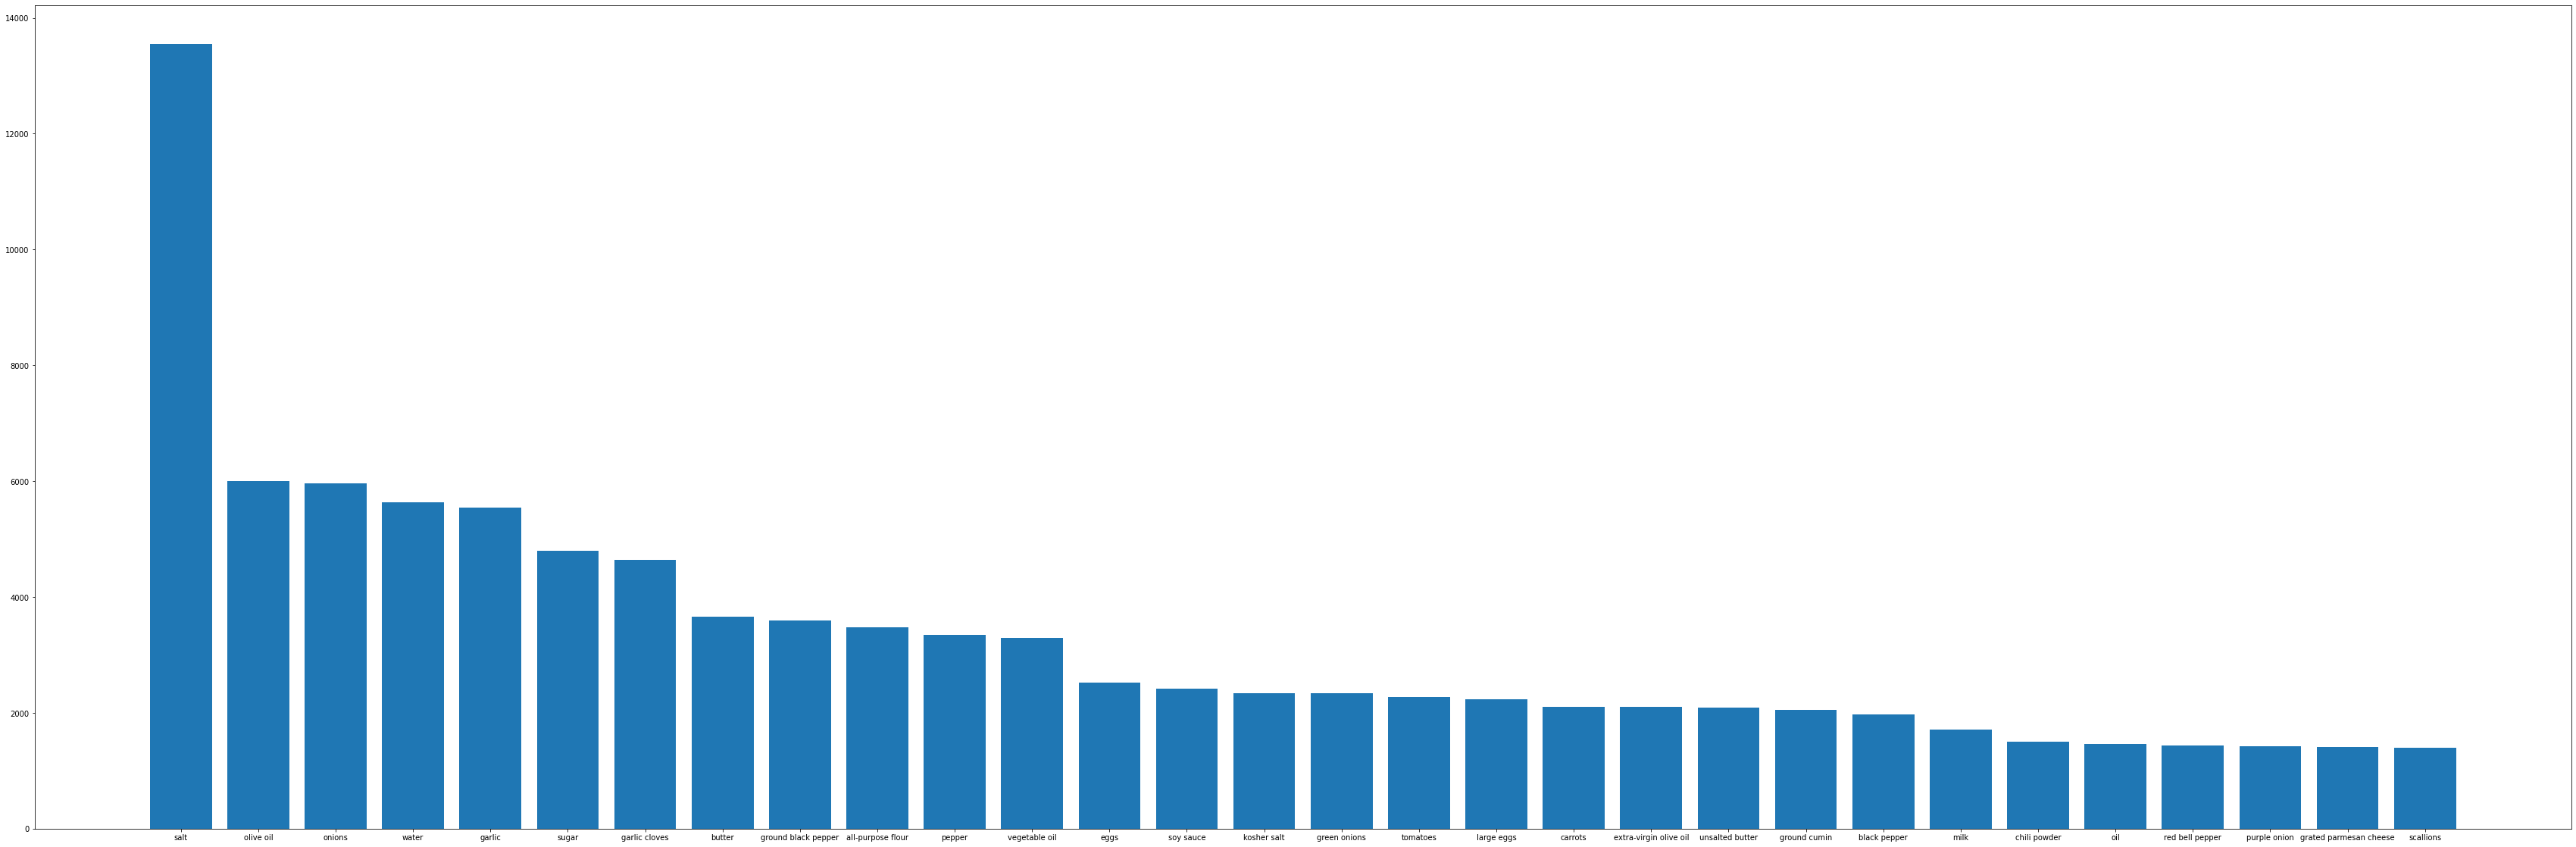

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (60,20))
(x, y) = np.unique(np.hstack(features), return_counts=True)
idx = np.argsort(-y)[:30]
plt.bar(np.array(ingredients)[x[idx]], y[idx])
plt.show()

**Plot the data distribution by value count of the number of ingredients**

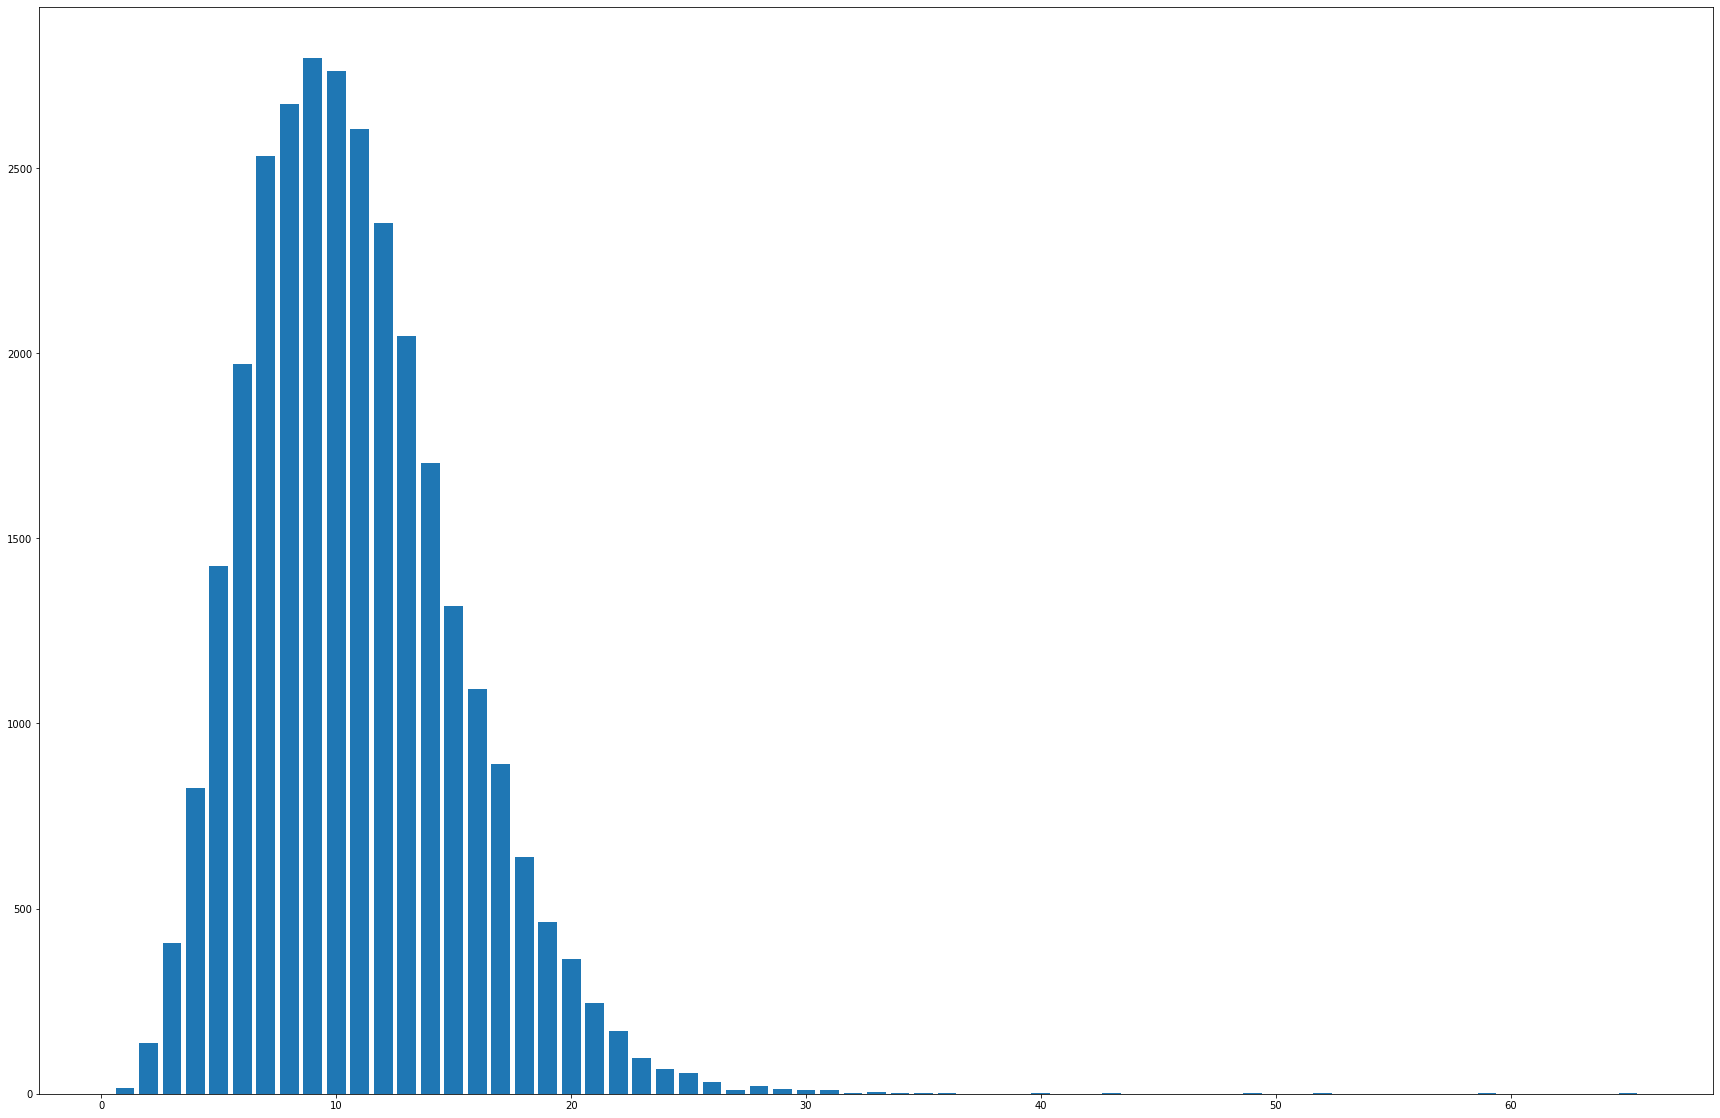

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (30,20))
(x, y) = np.unique([len(feature) for feature in features], return_counts=True)
plt.bar(x, y)
plt.show()

**Transform data format and shape**

In [ ]:
def encode(x):
  encoding = np.zeros(len(ingredients), dtype=np.int8)
  encoding[x] = 1
  return encoding

features = np.array([encode(feature) for feature in features])
recipes = np.column_stack((labels, features))

**Holdout validation**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(recipes[:,1:], recipes[:,0], test_size=0.3)
train = np.column_stack((y_train, x_train))

**Artificial Neural Networks**

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.Sequential(
    torch.nn.Linear(len(ingredients), 1000),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(1000, 20)
).to(device)

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 500)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

x_test_tensor = torch.from_numpy(x_test).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

for epoch in range(75):
  np.random.shuffle(train)
  x_train = torch.from_numpy(train[:, 1:]).to(device)
  y_train = torch.from_numpy(train[:, 0]).to(device)

  optimizer.zero_grad()

  model.train()
  output  = model(x_train.float())
  loss = criterion(output.float(), y_train.long())
  loss.backward()
  optimizer.step()

  model.eval()
  test_output = model(x_test_tensor.float())
  test_loss = criterion(test_output.float(), y_test_tensor.long())
  # print("Epoch:", epoch + 1, " Train:", loss.item(), " Test:", test_loss.item())

  scheduler.step()

# print('')
# x_train = torch.from_numpy(train[:, 1:]).to(device)
# y_train = train[:, 0]
# output = model(x_train.float())
# _, pred = torch.max(output, 1)
# pred = pred.detach().cpu().numpy()
# print('Training:', accuracy_score(y_train, pred))


# output = model(x_test_tensor.float())
# _, pred = torch.max(output, 1)
# pred = pred.detach().cpu().numpy()
# print('Testing:', accuracy_score(y_test, pred))

**Results**

In [ ]:
output = model(x_test_tensor.float())
_, pred = torch.max(output, 1)
pred = pred.detach().cpu().numpy()

print('Confusion matrix')
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, target_names=cuisines))

Confusion matrix
[[ 755    4   35    0   33    5   44    3    5   41    6    3    5    1
     0    4    9    0    1    1]
 [  12  186    0    0   46    1    8    4    2    7    1    1    0    0
     0    1    0    0    0    0]
 [  69    0  234    0   18    1    9    0    1   14    4    0    0    0
     1    1    1    0    0    2]
 [   1    1    0  118    1    1    0    0    0    3    1    9   21    2
     3    0    0    1    1    0]
 [  57   15    6    0 1580    2   94    4    3   28    9    1    2    1
     0    2    2    4    0    2]
 [   6    1    2    2    5   99    4    0    2   10    0    5   19    5
     6    1    1    1    0    1]
 [  36    2    9    0  133    0  378    2    3   11    6    3    1    1
     1    7    8    7    0    0]
 [   3    6    0    0   12    0    6  115    7    7    2    2    0    0
     0    0    1    0    0    0]
 [   8    3    0    0    9    2    3   15  603    9    3    6    3    5
     0    1    1    1    0    0]
 [  32    1    4    0   26    2   20  

**Kaggle Submission**

In [ ]:
with open('test.json') as f:
  json_data = json.load(f)

ids = []
test_features = []

for entry in json_data:
  ids.append(entry['id'])
  feature = []
  for ingredient in entry['ingredients']:
    if ingredient in ingredients:
      feature.append(ingredients.index(ingredient))
    else:
      # print(str(entry['id']))
      # print('unknown ingreditent: ' + ingredient)
      continue
  test_features.append(np.array(feature))

test_features = np.array([encode(feature) for feature in test_features])

In [ ]:
import pandas as pd

output = model(torch.from_numpy(test_features).to(device).float())
_, pred = torch.max(output, 1)
pred = pred.detach().cpu().numpy()

predictions = {'id': ids, 'Category': np.array(cuisines)[pred]}
predictions = pd.DataFrame(data=predictions)
predictions.to_csv("y_test.csv", index=False)

**Data Augmentation**

In [ ]:
!pip install Unidecode

import re
import unidecode

def simplify(ingredient):
  ingredient = ingredient.lower() #Lower - Casing
  ingredient = ingredient.replace('-', ' ') # Removing Hyphen
  words = []
  for word in ingredient.split():
    word = unidecode.unidecode(word) #Removing accents
    word = re.sub('[0-9]','',word) #removing numbers,punctuations and special characters
    word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'),'',word) # Removing Units
    if len(word) <= 2: continue # Removing words with less than two characters
    words.append(word)
  return ' '.join(words)

In [ ]:
simple_ingredients = []
mapping = [] # map simple_ingredients to ingredients
rmv_idx = [] # index of ingredients to remove

for ingredient in ingredients:
  simple_ingredient = simplify(ingredient)
  if not simple_ingredient:
    rmv_idx.append(ingredients.index(ingredient))
    continue
  
  if simple_ingredient in simple_ingredients:
    idx = mapping[simple_ingredients.index(simple_ingredient)]
    features[:, idx] = features[:, idx] | features[:, ingredients.index(ingredient)]
    rmv_idx.append(ingredients.index(ingredient))
  else:
    simple_ingredients.append(simple_ingredient)
    mapping.append(ingredients.index(ingredient))

simple_features = np.delete(features, rmv_idx, 1)
simple_recipes = np.column_stack((labels, simple_features))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(simple_recipes[:,1:], simple_recipes[:,0], test_size=0.3)
train = np.column_stack((y_train, x_train))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.Sequential(
    torch.nn.Linear(len(simple_ingredients), 1000),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(1000, 20)
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, 500)

x_test_tensor = torch.from_numpy(x_test).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

for epoch in range(75):
  np.random.shuffle(train)
  x_train = torch.from_numpy(train[:, 1:]).to(device)
  y_train = torch.from_numpy(train[:, 0]).to(device)

  optimizer.zero_grad()

  model.train()
  output  = model(x_train.float())
  loss = criterion(output.float(), y_train.long())
  loss.backward()
  optimizer.step()

  model.eval()
  test_output = model(x_test_tensor.float())
  test_loss = criterion(test_output.float(), y_test_tensor.long())
  # print("Epoch:", epoch + 1, " Train:", loss.item(), " Test:", test_loss.item())

  scheduler.step()

# print('')
# x_train = torch.from_numpy(train[:, 1:]).to(device)
# y_train = train[:, 0]
# output = model(x_train.float())
# _, pred = torch.max(output, 1)
# pred = pred.detach().cpu().numpy()
# print('Training:', accuracy_score(y_train, pred))


# output = model(x_test_tensor.float())
# _, pred = torch.max(output, 1)
# pred = pred.detach().cpu().numpy()
# print('Testing:', accuracy_score(y_test, pred))

output = model(x_test_tensor.float())
_, pred = torch.max(output, 1)
pred = pred.detach().cpu().numpy()

print('Confusion matrix')
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, target_names=cuisines))

Confusion matrix
[[ 777    1   40    0   41    4   37    1    7   30    7    3    7    2
     0    5   10    9    6    0]
 [   3  169    1    0   52    0   14    6    3    3    4    0    0    0
     0    2    0    0    1    0]
 [  63    0  228    0   16    0   11    0    2    9    5    0    1    0
     0    0    1    0    0    0]
 [   0    0    0  121    2    2    4    0    0    2    1    7   28    0
     3    0    0    0    1    0]
 [  42   21    8    0 1567    1   88    5    4   16   19    2    1    1
     0    7    4    4    0    3]
 [   8    0    2    3    4   97    5    0    2    5    2    4   13    8
     4    0    1    0    0    2]
 [  34    4    9    0  105    1  353    4    3    8    3    4    0    0
     1    4   11    8    1    0]
 [   2   13    0    0    9    0    3  148   27   10    4    0    0    1
     0    0    1    0    3    0]
 [   7    3    0    0    9    1    3   10  624   11    2   11    4    1
     1    1    2    2    2    1]
 [  36    4   12    0   29    3    4  